In [25]:
using JuMP, Ipopt, Plots, LaTeXStrings

In [26]:
include("params.jl");
S = S * 10

Using a time step $\Delta=1\, hr$ and a forecast length of $T=24\,hr$, the cost is just a sum of the decision variables at each time step

In [33]:
S*αꜝ/Cᵢ

0.003511351351351351

In [28]:
model = Model(Ipopt.Optimizer);

# Optimization Variables
@variable(model, ϕ_h_gas[1:Nₜ] .>= 0)
@variable(model, ϕ_h_elect[1:Nₜ] .>= 0)
@variable(model, ϕ_c_elect[1:Nₜ] .>= 0)
@variable(model, Tᵢₘₐₓ .>= Tᵢ[1:Nₜ] .>= Tᵢₘᵢₙ)
@variable(model, Tw[1:Nₜ, 1:Nₓ])

# Initial Conditions
@constraint(model, Tw[1,:] == Twᵒ)
@constraint(model, Tᵢ[1] == Tᵢᵒ)

# Dynamic Constraints
forcingfunc(k) = 1/Cᵢ * (ϕ_h_gas[k]+ϕ_h_elect[k]-ϕ_c_elect[k]-S*αꜝ*(Tᵢ[k]-Tw[k,1]))
    # Implicit (Backward) Euler in time
@constraint(model, [k in 1:Nₜ-1], Tᵢ[k+1] == Tᵢ[k] + Δt * forcingfunc(k+1))
    # Centered Difference in space
@constraint(model, [k in 1:Nₜ-1, j in 2:Nₓ-1], Tw[k+1,j] == 
                Tw[k,j] + Δt*β/(Δx)^2 * (Tw[k+1,j+1]-2*Tw[k+1,j]+Tw[k+1,j-1]))
# Boundary Conditions (O(Δx²) forward and backward diff. first derivatives at the tips)
@constraint(model, [k in 2:Nₜ], 0 == αꜝ*(Tᵢ[k]-Tw[k,1]) + κ/(2*Δx)*(-3*Tw[k,1]+4*Tw[k,2]-Tw[k,3]))
@constraint(model, [k in 2:Nₜ], 0 == αꜝꜝ*(Tw[k,Nₓ]-Tₐ[k]) + κ/(2*Δx)*(3*Tw[k,Nₓ]-4*Tw[k,Nₓ-1]+Tw[k,Nₓ-2]))

# Cost Function
cost(ϕ_h_gas, ϕ_h_elect, ϕ_c_elect) = C_gas * sum(ϕ_h_gas) + 
C_elec_onPeak * sum(ϕ_h_elect[1:13] + ϕ_c_elect[1:13]) + 
C_elec_offPeak * sum(ϕ_h_elect[14:24] + ϕ_c_elect[14:24]);
@objective(model, Min, cost(ϕ_h_gas, ϕ_h_elect, ϕ_c_elect));
#set_silent(model)


0.1 ϕ_h_gas[1] + 0.1 ϕ_h_gas[2] + 0.1 ϕ_h_gas[3] + 0.1 ϕ_h_gas[4] + 0.1 ϕ_h_gas[5] + 0.1 ϕ_h_gas[6] + 0.1 ϕ_h_gas[7] + 0.1 ϕ_h_gas[8] + 0.1 ϕ_h_gas[9] + 0.1 ϕ_h_gas[10] + 0.1 ϕ_h_gas[11] + 0.1 ϕ_h_gas[12] + 0.1 ϕ_h_gas[13] + 0.1 ϕ_h_gas[14] + 0.1 ϕ_h_gas[15] + 0.1 ϕ_h_gas[16] + 0.1 ϕ_h_gas[17] + 0.1 ϕ_h_gas[18] + 0.1 ϕ_h_gas[19] + 0.1 ϕ_h_gas[20] + 0.1 ϕ_h_gas[21] + 0.1 ϕ_h_gas[22] + 0.1 ϕ_h_gas[23] + 0.1 ϕ_h_gas[24] + 0.12 ϕ_h_elect[1] + 0.12 ϕ_c_elect[1] + 0.12 ϕ_h_elect[2] + 0.12 ϕ_c_elect[2] + 0.12 ϕ_h_elect[3] + 0.12 ϕ_c_elect[3] + [[...12 terms omitted...]] + 0.12 ϕ_h_elect[10] + 0.12 ϕ_c_elect[10] + 0.12 ϕ_h_elect[11] + 0.12 ϕ_c_elect[11] + 0.12 ϕ_h_elect[12] + 0.12 ϕ_c_elect[12] + 0.12 ϕ_h_elect[13] + 0.12 ϕ_c_elect[13] + 0.04 ϕ_h_elect[14] + 0.04 ϕ_c_elect[14] + 0.04 ϕ_h_elect[15] + 0.04 ϕ_c_elect[15] + 0.04 ϕ_h_elect[16] + 0.04 ϕ_c_elect[16] + 0.04 ϕ_h_elect[17] + 0.04 ϕ_c_elect[17] + 0.04 ϕ_h_elect[18] + 0.04 ϕ_c_elect[18] + 0.04 ϕ_h_elect[19] + 0.04 ϕ_c_elect[19] + 0.04 ϕ_h

In [29]:
optimize!(model);

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      488
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      192
                     variables with only lower bounds:       72
                variables with lower and upper bounds:       24
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.3999936e-02 1.00e+01 9.60e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [30]:
Tᵢ_t, ϕ_h_gas_t, ϕ_h_elect_t, ϕ_c_elect_t, Tw_t = value.(Tᵢ), value.(ϕ_h_gas), value.(ϕ_h_elect), value.(ϕ_c_elect), value.(Tw);

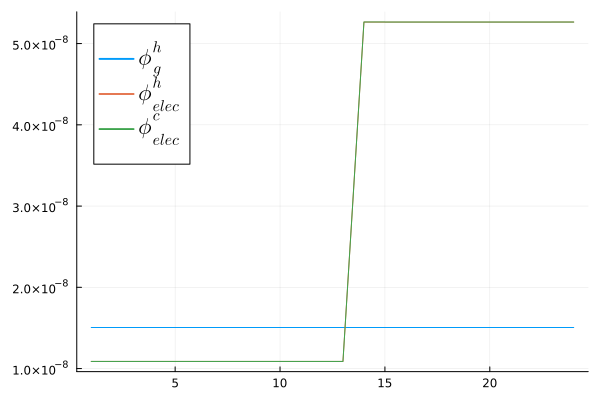

In [31]:
plot(ϕ_h_gas_t, label = L"$\phi_g^h$")
plot!(ϕ_h_elect_t, label = L"$\phi_{elec}^h$")
plot!(ϕ_c_elect_t, label = L"$\phi_{elec}^c$", legendfontsize=15)

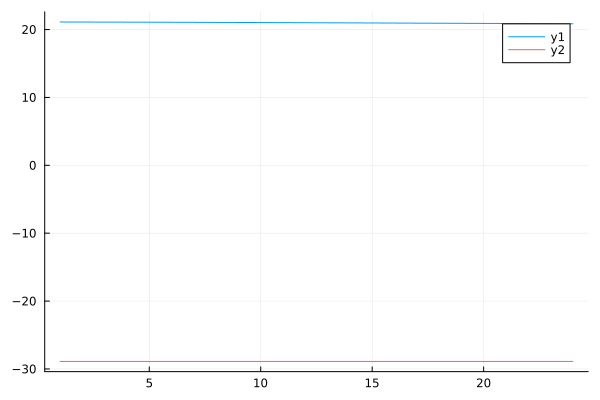

In [32]:
plot(Tᵢ_t)
plot!(Tₐ)

In [53]:
Tᵢ_t

24-element Vector{Float64}:
 70.0
 69.97398864944218
 69.94873341264945
 69.92149994317198
 69.89140747711696
 69.85840515183877
 69.82277794749274
 69.78491496885637
 69.74520632044795
 69.70400192739444
  ⋮
 69.43874175702422
 69.39293186337633
 69.34690423700162
 69.30070960696
 69.25438810561211
 69.20797146894083
 69.16148478628983
 69.11494788863571
 69.06837644848689

In [54]:
Tw_t

24×4 Matrix{Float64}:
 50.0     50.0     50.0       50.0
 63.307   50.1082  37.1798    -7.79916
 63.4755  48.4244  29.164    -10.136
 62.9412  46.1992  23.8939   -11.5864
 62.1784  43.9867  20.2641   -12.5331
 61.3995  42.0067  17.6635   -13.181
 60.6911  40.3221  15.7418   -13.6427
 60.0802  38.9276  14.2888   -13.9825
 59.5674  37.7908  13.1721   -14.2387
 59.1428  36.8719  12.3038   -14.4351
  ⋮                          
 57.7694  34.1171   9.83762  -14.982
 57.6513  33.9128   9.66379  -15.0198
 57.5495  33.7455   9.5233   -15.0502
 57.4605  33.6074   9.40911  -15.0747
 57.3817  33.4924   9.31569  -15.0946
 57.3109  33.3957   9.23868  -15.1108
 57.2464  33.3134   9.17464  -15.1242
 57.187   33.2425   9.12084  -15.1353
 57.1316  33.1807   9.07515  -15.1446

In [55]:
k = 1
 αꜝꜝ*(Tw_t[k,Nₓ]-Tₐ[k]) + κ/(2*Δx)*(3*Tw_t[k,Nₓ]-4*Tw_t[k,Nₓ-1]+Tw_t[k,Nₓ-2])


0.8119999999999999

In [56]:
k=2
value(1/Cᵢ*S*αꜝ*(Tᵢ[k]-Tw[k,1]))

0.026011350559623864